In [65]:
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
from sklearn import model_selection, linear_model, metrics
from osgeo import ogr, osr
import math
%matplotlib inline

/home/aleksey/projects/data_science/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
train_data = pd.read_csv('../../data/ny-taxi/train.csv')
weather_data = pd.read_csv('weather_data.csv')

# Exploratory Data Analysis

In [4]:
train_data.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

In [5]:
weather_data.head()

Date  Temperature  Rainfall  Atm_pressure  Wind_speed
0  2016-01-01            4       0.0          1017          13
1  2016-01-02            3       0.0          1017          16
2  2016-01-03            6       0.0          1012          16
3  2016-01-04           -2       0.0          1018           8
4  2016-01-05           -4       0.0          1036          10

In [73]:
weather_data['Date'] = weather_data['Date'].apply(pd.to_datetime)

In [75]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 5 columns):
Date            365 non-null datetime64[ns]
Temperature     365 non-null int64
Rainfall        365 non-null float64
Atm_pressure    365 non-null int64
Wind_speed      365 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 14.3 KB


In [6]:
len(train_data)

1458644

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [8]:
train_data['vendor_id'].unique()

array([2, 1])

In [9]:
train_data['passenger_count'].unique()

array([1, 6, 4, 2, 3, 5, 0, 7, 9, 8])

In [10]:
# drop id column
train_data = train_data.drop('id', 1)

In [11]:
train_data['pickup_datetime'] = train_data['pickup_datetime'].apply(pd.to_datetime)
train_data['dropoff_datetime'] = train_data['dropoff_datetime'].apply(pd.to_datetime)

In [79]:
train_data['date'] = train_data['pickup_datetime'].dt.date
train_data['date'] = train_data['date'].apply(pd.to_datetime)

In [14]:
train_data.head()

vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
0          2 2016-03-14 17:24:55 2016-03-14 17:32:30                1   
1          1 2016-06-12 00:43:35 2016-06-12 00:54:38                1   
2          2 2016-01-19 11:35:24 2016-01-19 12:10:48                1   
3          2 2016-04-06 19:32:31 2016-04-06 19:39:40                1   
4          2 2016-03-26 13:30:55 2016-03-26 13:38:10                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.982155        40.767937         -73.964630         40.765602   
1        -73.980415        40.738564         -73.999481         40.731152   
2        -73.979027        40.763939         -74.005333         40.710087   
3        -74.010040        40.719971         -74.012268         40.706718   
4        -73.973053        40.793209         -73.972923         40.782520   

  store_and_fwd_flag  trip_duration        date  
0                  N            455  2016-03-14  
1                  N            663  2016-06-12  
2                  N           2124  2016-01-19  
3                  N            429  2016-04-06  
4                  N            435  2016-03-26

In [15]:
# define function for calculation distance between pickup and dropoff points
def distance(pickup_x, pickup_y, dropoff_x, dropoff_y):
    source = osr.SpatialReference()
    source.ImportFromEPSG(4326)
    target = osr.SpatialReference()
    target.ImportFromEPSG(26918)
    transofrm = osr.CoordinateTransformation(source, target)
    line = ogr.Geometry(ogr.wkbLineString)
    line.AddPoint(pickup_x, pickup_y)
    line.AddPoint(dropoff_x, dropoff_y)
    line.Transform(transofrm)
    return line.Length()

In [48]:
# we must create new feature - distance between pickup and dropoff points
for i in range(1400000,len(train_data)):
    train_data.loc[i, 'distance'] = distance(train_data.loc[i, ['pickup_longitude']][0], train_data.loc[i, ['pickup_latitude']][0], train_data.loc[i, ['dropoff_longitude']][0], train_data.loc[i, ['dropoff_latitude']][0])

In [ ]:
# we will try to calculate distance with osrm
# https://github.com/ustroetz/python-osrm
import osrm

In [78]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1387233 entries, 1 to 1458643
Data columns (total 13 columns):
vendor_id             1387233 non-null int64
pickup_datetime       1387233 non-null datetime64[ns]
dropoff_datetime      1387233 non-null datetime64[ns]
passenger_count       1387233 non-null int64
pickup_longitude      1387233 non-null float64
pickup_latitude       1387233 non-null float64
dropoff_longitude     1387233 non-null float64
dropoff_latitude      1387233 non-null float64
store_and_fwd_flag    1387233 non-null object
trip_duration         1387233 non-null int64
date                  1387233 non-null object
distance              1387233 non-null float64
av_speed              1387233 non-null float64
dtypes: datetime64[ns](2), float64(6), int64(3), object(2)
memory usage: 188.2+ MB


In [50]:
train_data['av_speed'] = train_data['distance']/train_data['trip_duration']
train_data['av_speed'] = train_data['av_speed']*3.6

In [60]:
train_data = train_data.dropna()
len(train_data)

1458643

In [63]:
# remove trips with 0 passengers
train_data = train_data.loc[train_data['passenger_count'] != 0]
len(train_data)

1458583

In [64]:
train_data = train_data.loc[(train_data['av_speed'] > 5) & (train_data['av_speed'] < 120)]
len(train_data)

1387237

In [66]:
pandas_profiling.ProfileReport(train_data)

In [67]:
train_data = train_data.drop_duplicatesduplicates()

In [68]:
len(train_data)

1387233

In [80]:
merged_data = train_data.merge(weather_data, left_on='date', right_on = 'Date')

In [81]:
merged_data.head()

vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
0          1 2016-06-12 00:43:35 2016-06-12 00:54:38                1   
1          2 2016-06-12 14:38:15 2016-06-12 14:57:04                2   
2          1 2016-06-12 16:07:00 2016-06-12 16:40:36                1   
3          2 2016-06-12 01:24:01 2016-06-12 01:33:30                1   
4          1 2016-06-12 16:41:17 2016-06-12 16:52:38                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.980415        40.738564         -73.999481         40.731152   
1        -73.982536        40.772202         -73.984627         40.757069   
2        -73.977165        40.751816         -73.983261         40.693291   
3        -73.988190        40.723576         -73.987213         40.744808   
4        -73.983131        40.760345         -73.965454         40.763050   

  store_and_fwd_flag  trip_duration       date     distance   av_speed  \
0                  N            663 2016-06-12  1808.098438   9.817729   
1                  N           1129 2016-06-12  1689.220329   5.386354   
2                  N           2016 2016-06-12  6517.487787  11.638371   
3                  N            569 2016-06-12  2358.565805  14.922385   
4                  N            681 2016-06-12  1522.076691   8.046220   

        Date  Temperature  Rainfall  Atm_pressure  Wind_speed  
0 2016-06-12           24       0.0          1005          10  
1 2016-06-12           24       0.0          1005          10  
2 2016-06-12           24       0.0          1005          10  
3 2016-06-12           24       0.0          1005          10  
4 2016-06-12           24       0.0          1005          10

In [88]:
merged_data.groupby('vendor_id')['trip_duration'].max()

vendor_id
1    17363
2    14040
Name: trip_duration, dtype: int64

In [90]:
merged_data = merged_data.drop(['Date', 'date'], 1)

In [96]:
merged_data = merged_data[(merged_data['trip_duration'] > merged_data['trip_duration'].quantile(.025)) & 
                         (merged_data['trip_duration'] < merged_data['trip_duration'].quantile(.99))]

In [97]:
len(merged_data)

1331297

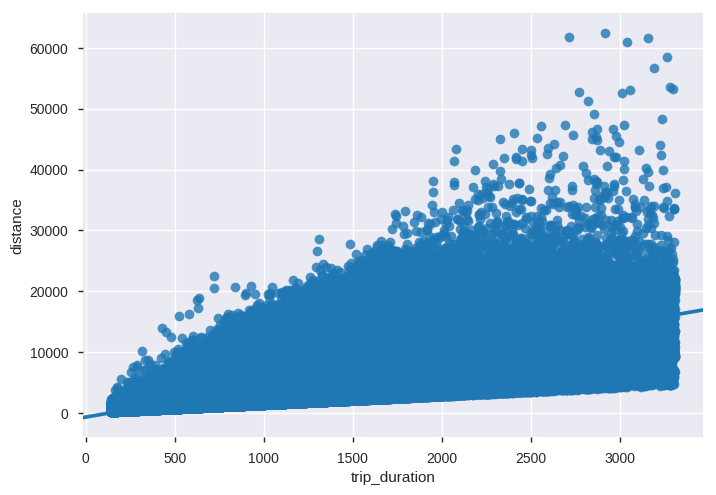

In [99]:
sns.regplot(merged_data.loc[:,'trip_duration'], merged_data.loc[:,'distance'])

In [100]:
# создадим еще два признака
merged_data['month'] = merged_data['pickup_datetime'].apply(lambda x: x.month)
merged_data['hour'] = merged_data['pickup_datetime'].apply(lambda x: x.hour)

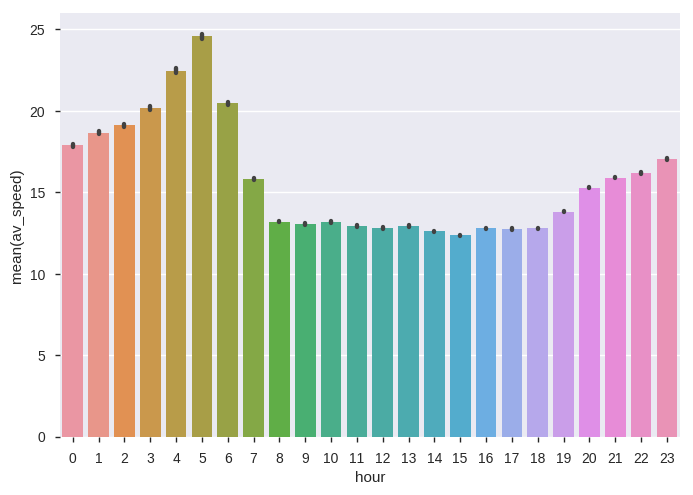

In [103]:
sns.barplot(x = merged_data['hour'], y = merged_data['av_speed'])

In [142]:
numerical_data = merged_data.loc[:, ['vendor_id', 'passenger_count', 'distance', 'trip_duration', 'Rainfall', 'Temperature']]

In [151]:
merged_data.to_csv('train.csv')

In [143]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(numerical_data)
scaled_data = scaler.transform(numerical_data)

## Modeling

In [150]:
# first we try to fit simple regression models by one parameter distance
linreg = linear_model.LinearRegression()
tr, ts = model_selection.train_test_split(numerical_data)
sgr = linear_model.SGDRegressor()
las = linear_model.Lasso()

/home/aleksey/projects/data_science/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [145]:
print(len(tr))
print(len(ts))

998472
332825


In [148]:
linreg.fit(numerical_data[['distance', 'Rainfall', 'Temperature', 'passenger_count']], numerical_data['trip_duration'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [149]:
score = model_selection.cross_val_score(linreg, numerical_data[['distance', 'Rainfall', 'Temperature', 'passenger_count']], numerical_data['trip_duration'], scoring='r2', cv = 10)
score.mean()

0.58891504024551045

In [125]:
sgr.fit(merged_data[['distance', 'Rainfall']], merged_data['trip_duration'])

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=5, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [131]:
sgr_score = model_selection.cross_val_score(sgr, merged_data[['distance', 'Rainfall']], merged_data['trip_duration'], scoring='neg_mean_squared_error', cv = 10)
sgr_score.mean()

-3.1930226317880091e+31

In [111]:
metrics.mean_absolute_error(ts['trip_duration'], lr_predictions)

NameError: name 'lr_predictions' is not defined

In [176]:
metrics.mean_squared_error(ts['trip_duration'], lr_predictions)

166403.1207267539

In [186]:
metrics.r2_score(ts['trip_duration'], lr_predictions)

0.61073741677480342

In [199]:
score = model_selection.cross_val_score(linreg, train_data['distance'].reshape(len(train_data), 1), train_data['trip_duration'].reshape(len(train_data), 1), scoring='neg_mean_squared_error', cv = 10)
score.mean()

/home/aleksey/projects/data_science/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


-167760.71933044045

In [205]:
models = [linear_model.LinearRegression(), linear_model.Lasso(), linear_model.Ridge(), linear_model.ElasticNet(), linear_model.SGDRegressor()]

In [208]:
for model in models:
    clf = model
    clf.fit(train_data['distance'].reshape(len(train_data), 1), train_data['trip_duration'].reshape(len(train_data), 1))
    score = model_selection.cross_val_score(clf, train_data['distance'].reshape(len(train_data), 1), train_data['trip_duration'].reshape(len(train_data), 1), scoring='r2', cv = 10)
    print(model, '\n', score.mean())

/home/aleksey/projects/data_science/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/aleksey/projects/data_science/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False) 
 0.609757962008


/home/aleksey/projects/data_science/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/aleksey/projects/data_science/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False) 
 0.609757962052


/home/aleksey/projects/data_science/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/aleksey/projects/data_science/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001) 
 0.609757962008


/home/aleksey/projects/data_science/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/aleksey/projects/data_science/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False) 
 0.609757962033


/home/aleksey/projects/data_science/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/aleksey/projects/data_science/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aleksey/projects/data_science/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.
/home/aleksey/projects/data_science/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. P

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False) 
 -5.16725060141e+25


In [229]:
clf = linear_model.Ridge()
clf.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [ ]:
#TODO add time features, holiday/workday features, meteo features, road graph distance
# TODO create sklearn pipline

In [152]:
#TODO use RandomForest and xgboost
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

In [155]:
rf.fit(numerical_data[['distance', 'Rainfall', 'Temperature', 'passenger_count']], numerical_data['trip_duration'])

rf_score = model_selection.cross_val_score(linreg, numerical_data[['distance', 'Rainfall', 'Temperature', 'passenger_count']], numerical_data['trip_duration'], scoring='r2', cv = 10)
rf_score.mean()

0.58891504024551045